# WPROWADZENIE DO SZTUCZNEJ INTELIGENCJI - LABORATORIUM 7

+ AUTOR: **ŁUKASZ STANISZEWSKI**
+ NR INDEKSU: **304098**
+ ADRES E-MAIL: **lukasz.staniszewski.stud@pw.edu.pl**
+ KIERUNEK: **INFORMATYKA**
+ PRZEDMIOT: **Wprowadzenie do sztucznej inteligencji**
+ ZADANIE: **[LINK](https://apps.usos.pw.edu.pl/apps/f/ZA8E6TMF/lab7.pdf)**
+ SYSTEM OPERACYJNY: **Windows 10**
+ JĘZYK PROGRAMOWANIA: **Python 3.8**
+ TEMAT: **Implementacja algorytmu Q-learning, działającego na dowolonym środowisku OpenAI gym, o dyskretnych przestrzeniach akcji oraz stanów i przetestowanie jego działania na środowisku FrozenLake8x8-v0.**

## 1. Działania wstępne
### 1.1. Import niezbędnych modułów
+ **pyplot** oraz **seaborn** - wykresy
+ **numpy** - macierze, tablice
+ **gym** - biblioteka gym
+ **math** - biblioteka do obliczeń matematycznych
+ **random** - generowanie liczb pseudolosowych

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import gym
import math
import random

### 1.2. Ustawienie ziarna generatora dla powtarzalności

In [2]:
np.random.seed(100)
random.seed(100)

## 2. Biblioteka GYM
### 2.1. Opis
+ Zaimplementowany algorytm powinien być kompatybilny z dowolnym środowiskiem OpenAI GYM. OpenAI GYM jest zestawem narzędzi do badania algorytmów uczenia ze wzmocnieniem. W ramach tej pracy zostanie zaimplementowany algorytm QLearning wykorzystujący strategię epsilon-zachłanną do wyboru akcji.
+ Algorytm będzie dążył do tego, żeby % sukcesów w n ostatnich epizodach był jak najwyższy. 

### 2.2. Użycie biblioteki, przydatne funkcje
+ W celu zainicjowania środowiska użyta zostanie metoda **gym.make(nazwa_środowiska)**, w nastepnych sekcjach pracy środowisko, jakie będzie używane to **FrozenLake8x8**.
+ W celu zainicjowania agenta na środowisku, zostanie użyta metoda **gym.reset(środowisko)**.
+ Jeśli będzie konieczne wybranie następnej akcji losowo, zostanie użyta metoda **action_space.sample(environment)**.
+ Ostatnią użytą metodą będzie wykonanie akcji przez agenta, zostanie to zrealizowane za pomocą funkcji **środowisko.step(akcja)**.

### 2.3. Działanie dla losowych ruchów
+ Teraz zostanie zaprezentowane działanie biblioteki OpenAI GYM dla losowego wybierania następnego kroku.

In [3]:
N_OF_EPISODES = 100000
environment = gym.make('FrozenLake8x8-v0')
rewards = []
last1000rewards=0
for episode in range(N_OF_EPISODES):
    observation = environment.reset()
    sum_rew = 0
    for t in range(300):
        action = environment.action_space.sample()
        observation, reward, done, info = environment.step(action)
        sum_rew += reward
        if done:
            break
    last1000rewards+= sum_rew
    if episode%1000 == 0:
        rewards.append(last1000rewards)
        print(f"Sum of rewards for last 1000 episodes: {last1000rewards}")
        last1000rewards = 0
environment.close()

Sum of rewards for last 1000 episodes: 0.0
Sum of rewards for last 1000 episodes: 3.0
Sum of rewards for last 1000 episodes: 0.0
Sum of rewards for last 1000 episodes: 2.0
Sum of rewards for last 1000 episodes: 3.0
Sum of rewards for last 1000 episodes: 1.0
Sum of rewards for last 1000 episodes: 2.0
Sum of rewards for last 1000 episodes: 3.0
Sum of rewards for last 1000 episodes: 4.0
Sum of rewards for last 1000 episodes: 1.0
Sum of rewards for last 1000 episodes: 2.0
Sum of rewards for last 1000 episodes: 1.0
Sum of rewards for last 1000 episodes: 3.0
Sum of rewards for last 1000 episodes: 2.0
Sum of rewards for last 1000 episodes: 0.0
Sum of rewards for last 1000 episodes: 2.0
Sum of rewards for last 1000 episodes: 1.0
Sum of rewards for last 1000 episodes: 3.0
Sum of rewards for last 1000 episodes: 1.0
Sum of rewards for last 1000 episodes: 0.0
Sum of rewards for last 1000 episodes: 4.0
Sum of rewards for last 1000 episodes: 1.0
Sum of rewards for last 1000 episodes: 0.0
Sum of rewa

+ Dodatkowo zostanie przedstawiony wykres pokazujący sumę nagród z ostatnich 1000 epizodów przed danym epizodem.

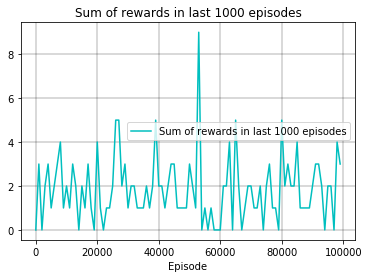

<Figure size 432x288 with 0 Axes>

In [4]:
def create_plot(title, indexes, values, labels, colors, linestyles):
    if(len(values)!=len(labels)!=len(colors)!=len(linestyles)):
        print("BAD ARGS")
        return
    # every plot
    for iterator in range(len(values)):
        plt.plot(indexes, values[iterator], color=colors[iterator], linestyle=linestyles[iterator], label=labels[iterator])
    # setting title
    plt.title(title)
    plt.ticklabel_format(style="plain", useOffset=True)
    plt.xlabel("Episode")
    # showing grid
    plt.grid(True, linewidth=0.3, color='black')
    # showing legend
    plt.legend()
    plt.show()
    plt.clf()
    
indexes = [it*1000 for it, val in enumerate(rewards)]
values=[rewards]
labels=["Sum of rewards in last 1000 episodes"]
colors=["c"]
linestyles=["-"]
create_plot("Sum of rewards in last 1000 episodes", indexes, values, labels, colors, linestyles)

+ W przypadku środowiska FrozenLake8v8 w ramach 1 epizodu suma nagród może wynosić 0 lub 1 (0 dla wyjścia poza środowisko/wejście w "dziurę", a 1 gdy udało się dojść do celu).
+ Jak widać w przypadku losowego doboru akcji w danym stanie, na 1000 epizodów średnio 2 razy udaje się dotrzeć do celu, do tego niezależnie od tego w którym epizodzie jest już środowisko, efektywność działania agenta nie zwiększa się.

## 3. Algorytm QLearning
### 3.1. Wstępny opis
+ Algorytm QLearning ma za zadanie utrzymywać funkcję wartości-akcji (Q), która ma zbiegać do optymalnej wersji tej funkcji.
+ Wersja algorytmu zastosowana w tej pracy będzie używała strategii epsilon-zachłannej do wyboru optymalnej akcji w danym stanie.

### 3.2. Algorytm
+ Dane wejściowe obowiązkowe: ŚRODOWISKO OpenAI GYM 
+ Dane wejściowe ewentualne: $ β, ϒ, epsilon, episodes, liczbaKrokówCzasowych $
    + dodatkwo zmienna $numberLastBest$ definiująca po ilu epizodach należy obliczyć sumę nagród
+ Kroki:
    1. Zainicjalizuj funkcję Q
    2. Dla każdego epizodu = 1...$episodes$
        1. Dla każdego t = 1...$liczbaKrokówCzasowych$
            1. Wylosuj akcję zgodnie z założoną strategią
            2. Wykonaj akcję wylosowaną, zarejestruj następny stan, nagrodę za poprzedni stan i informację czy jest się w stanie terminalnym
            3. $$ Q(stan_t, akcja_t) = Q(stan_t, akcja_t) + β_t(nagroda_t + ϒ*max_u(Q(stan_{t+1},akcja)-Q(stan_t, akcja_t))) $$
            4. Jeśli agent w stanie terminalnym, opuść aktualną pętlę
            

### 3.3. Strategia epsilon-zachłanna
+ Dane wejściowe: $ funkcjaQ, środowisko, epsilon, aktualnyStan $
+ Kroki:
    1. Wylosuj liczbę $x$ z zakresu $<0,1>$
    2. Jeśli $ x < epsilon $:
        1. $ akcja $ = wybrana losowo akcja z przestrzeni akcji w $środowisko$
    3. W przeciwnym przypadku:
        1. $ akcja $ = wybierz akcję, która jest najlepsza w $aktualnyStan$ na podstawie funkcjaQ
    2. Zwróć $ akcja $
    
### 3.4. Implementacje funkcji

In [5]:
def qLearning(environment, **kwargs):
    # kwargs and setting params
    beta = kwargs.get('beta', 0.7)
    gamma = kwargs.get('gamma', 0.90)
    timeStamps = kwargs.get('timestamps', 200)
    numberEpisodes = kwargs.get('nofepisodes', 25000)
    numberLastBest = kwargs.get('lastBest', 1000)
    epsilon = kwargs.get('epsilon', 0.1)
    # Q is being zeroed
    qTable = np.zeros([environment.observation_space.n, environment.action_space.n])
    rewards = []
    rewardNEpisodes = 0
    # for every episode
    for episode in range(1, numberEpisodes+1):
        state_t = environment.reset()
        rewardEpisode = 0
        timestamp = 0
        # for every t
        while timestamp <= timeStamps:
            timestamp += 1
            # choose action with epsilon
            action_t = chooseEpsilon(qTable, environment, epsilon, state_t)
            # make step and remember all important environment informations 
            state_t1, reward_t, isDone, info = environment.step(action_t)
            # update qTable
            old_value = qTable[state_t, action_t]
            next_max = np.max(qTable[state_t1])
            new_value = (1 - beta) * old_value + beta * (reward_t + gamma * next_max)
            qTable[state_t, action_t] = new_value
            rewardEpisode += reward_t
            # actual state = next_state
            state_t = state_t1
            if isDone is True:
                break
        rewardNEpisodes += rewardEpisode
        # for each numberLastBest episodes, remember information how many was good
        if episode % numberLastBest == 0:
            rewards.append(rewardNEpisodes)
            rewardNEpisodes = 0
    return rewards


def chooseEpsilon(qTable, environment, epsilon, state_t):
    # if random() < epsilon
    if random.uniform(0, 1) < epsilon:
        # choose random action
        action_t = environment.action_space.sample()
    else:
        # choose action which value is biggest
        # if there are n actions with similiar values, choose best randomly
        it_best = []
        val_max = -math.inf
        for it, val in enumerate(qTable[state_t]):
            if val > val_max:
                val_max = val
                it_best.clear()
                it_best.append(it)
            elif val == val_max:
                it_best.append(it)
        action_t = random.choice(it_best)
    return action_t

## 4. Test na środowisku FrozenLake8x8
### 4.1. Informacje co do testów
+ Ze względu na losowość środowiska, badania będą wykonywane jako średnia z 5 uruchomień.
+ Następnie po wykonaniu uśrednień zostaną przedstawione wyniki w formie wykresu, gdzie dla danego epizodu, przedstawiona zostanie liczba sukcesów (ile razy nastąpiło dojście do celu) w 1000 ostatnich epizodach.

### 4.2. Parametry do przebadania i ich wartości
+ Za parametry z góry ustalone zostały uznane:
    + $ episodes = 30.000 $
    + $ numberLastBest = 100 $
    + $ timeStamps = 200 $
+ Za parametry do przebadania zostały uznane:
    + $ beta = [0.05, 0.1, 0.3, 0.5, 0.7, 1.0] $
    + $ gamma = [0.1, 0.3, 0.6, 0.8, 0.9, 1.0] $
    + $ epsilons = [0.001, 0.005, 0.01, 0.05, 0.1, 0.15] $
    
### 4.3. Testy
+ parametry:

In [6]:
betas = [0.05, 0.1, 0.3, 0.5, 0.7, 1.0]
gammas = [0.1, 0.3, 0.6, 0.8, 0.9, 1.0]
epsilons = [0.001, 0.005, 0.01, 0.05, 0.1, 0.15]
N_OF_RUNS = 5
EPISODES = 30000
TIME_STAMPS = 200
N_OF_LAST_BEST = 100

+ pomocne funkcje:

In [7]:
def validation():
    indexes = [it * N_OF_LAST_BEST for it in range(1, int(EPISODES / N_OF_LAST_BEST) + 1)]
    colors = ["c"]
    linestyles = ["-"]
    environment = gym.make('FrozenLake8x8-v0')
    # for each param
    for beta in betas:
        for gamma in gammas:
            for epsilon in epsilons:
                list_of_results = []
                # for each run get list of results 
                for run in range(N_OF_RUNS):
                    list_of_results.append(qLearning(environment, beta=beta, gamma=gamma, epsilon=epsilon,
                                                     timestamps=TIME_STAMPS, nofepisodes=EPISODES,
                                                     lastBest=N_OF_LAST_BEST))
                # avarage results from all N_OF_RUNS runs
                sums_results = [0 for _ in range(len(list_of_results[0]))]
                for ind_i in range(len(list_of_results[0])):
                    for ind_j in range(len(list_of_results)):
                        sums_results[ind_i] += list_of_results[ind_j][ind_i]
                for ind_i in range(len(sums_results)):
                    sums_results[ind_i] = sums_results[ind_i] / len(list_of_results)
                namePlot = f"Sum of successess with beta={beta}, gamma={gamma}, epsilon={epsilon}"
                labels = [namePlot]
                # plot result
                create_plot(namePlot, indexes, [sums_results], labels, colors, linestyles)

+ wyniki:

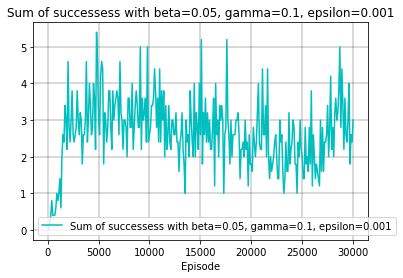

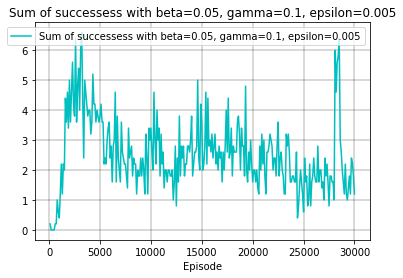

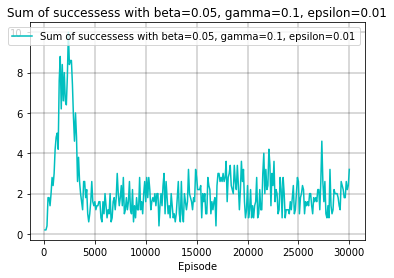

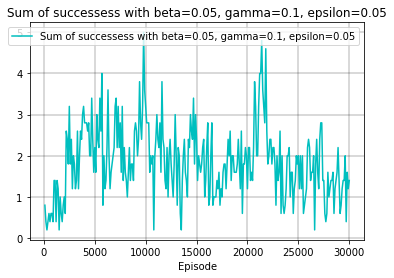

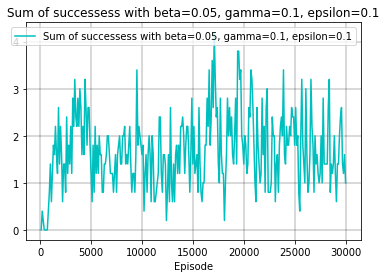

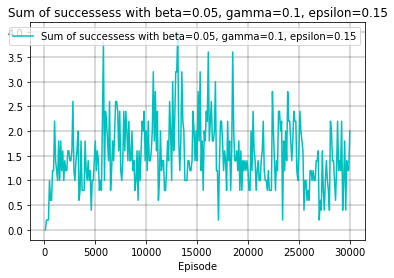

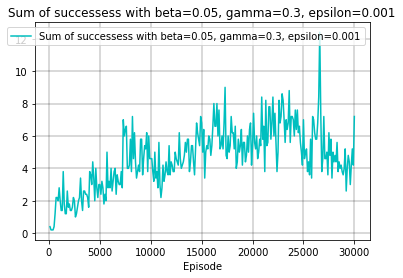

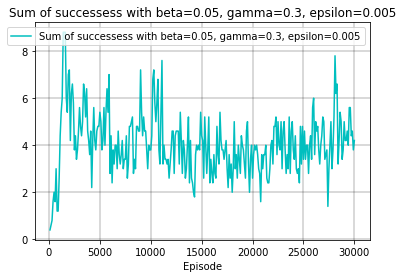

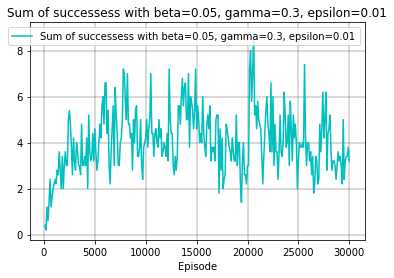

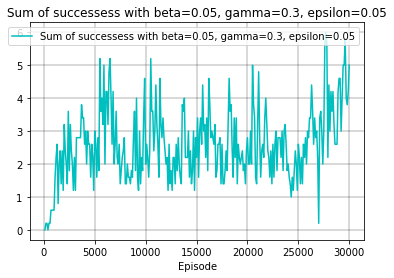

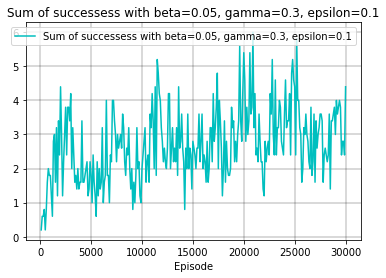

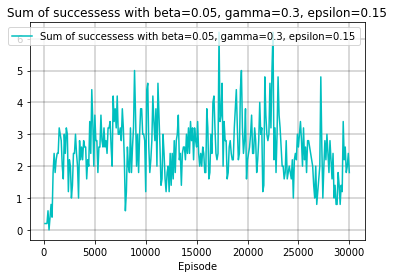

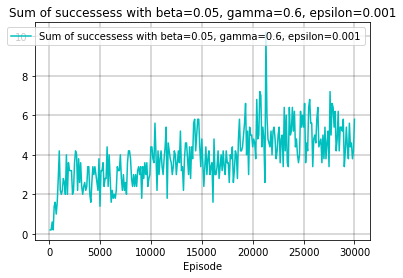

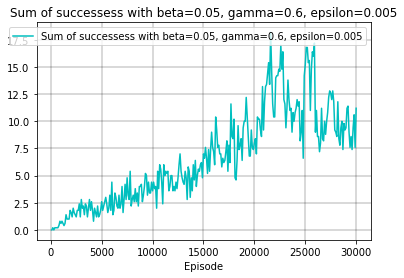

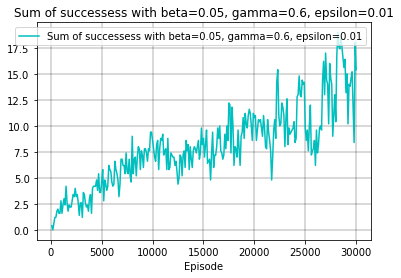

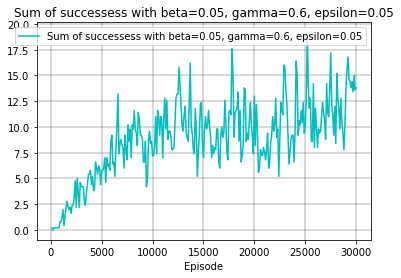

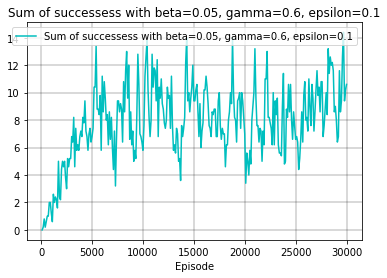

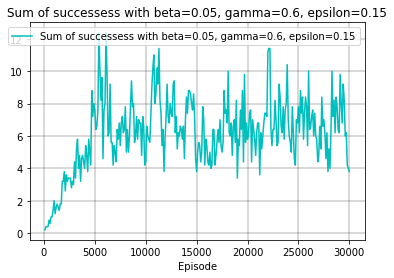

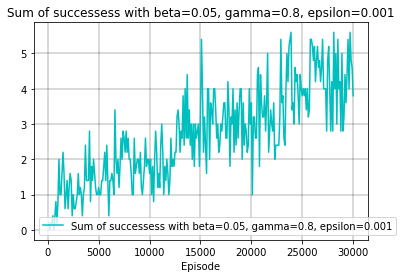

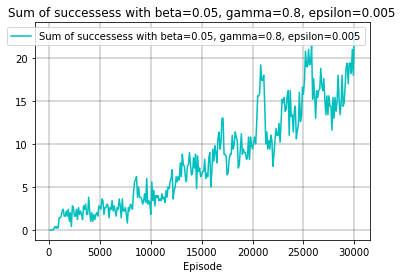

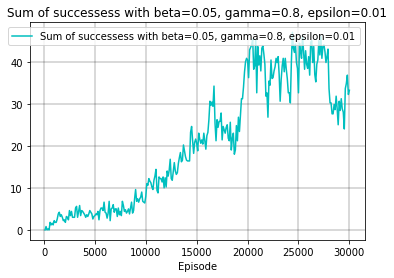

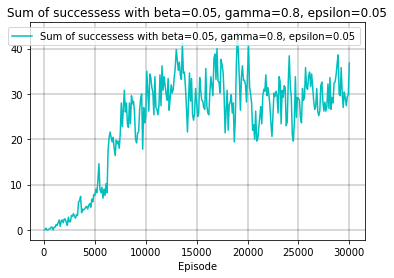

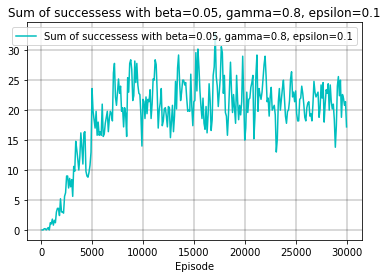

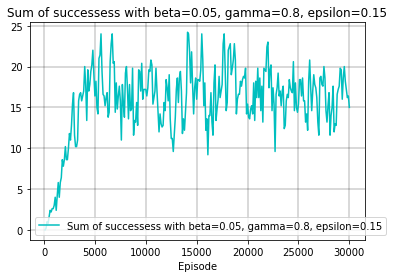

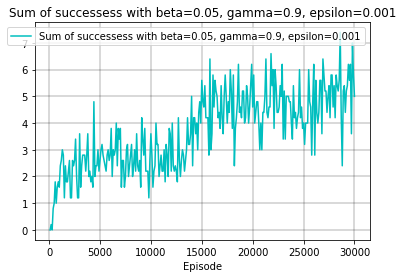

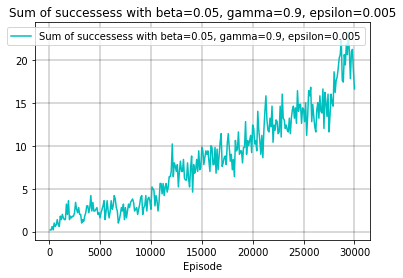

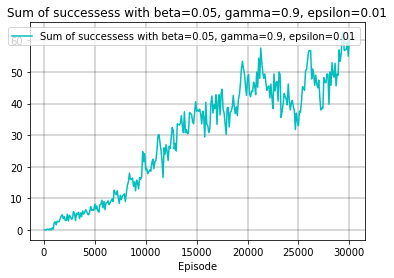

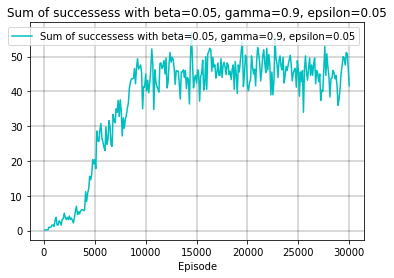

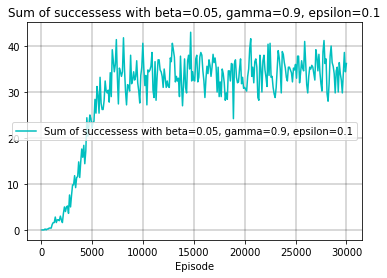

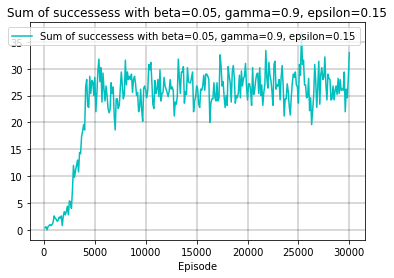

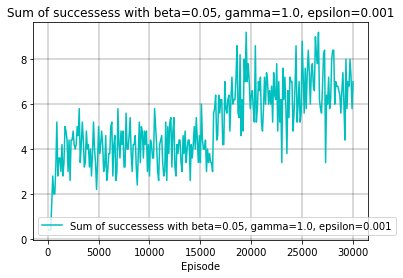

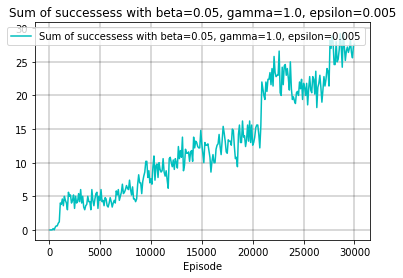

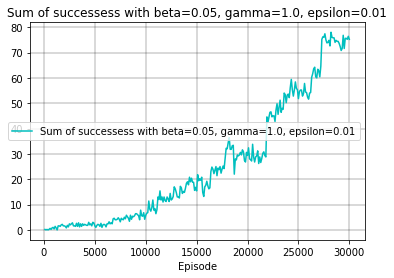

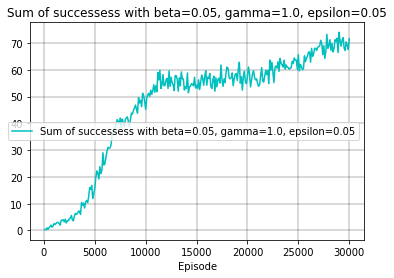

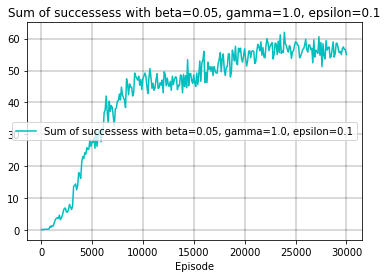

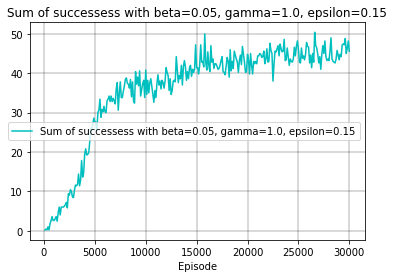

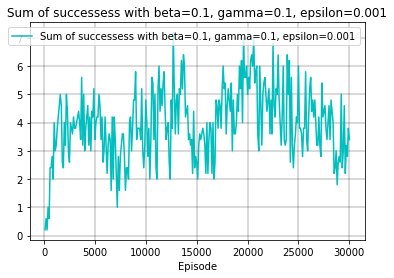

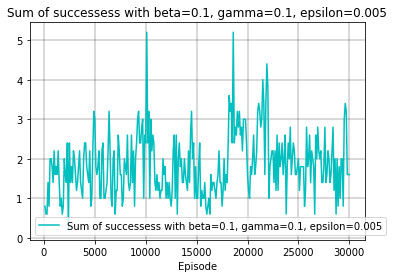

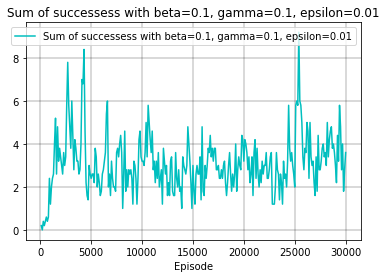

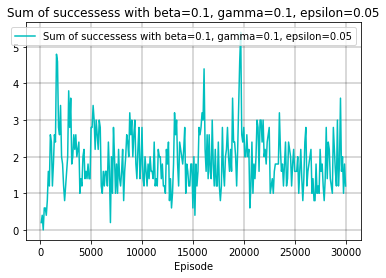

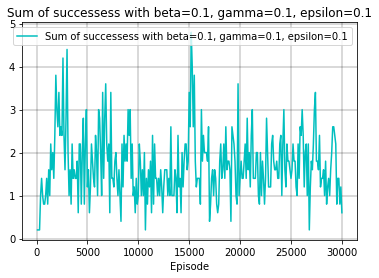

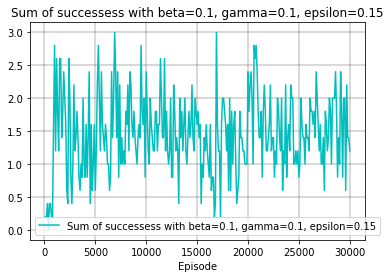

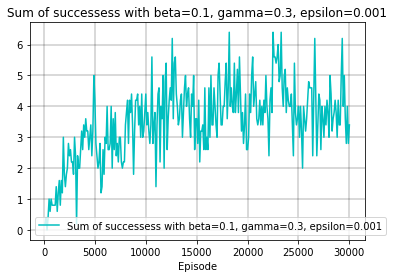

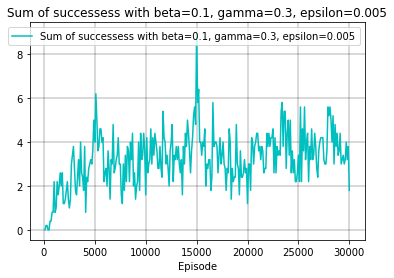

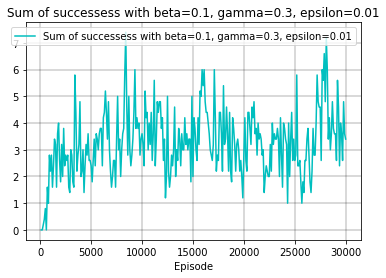

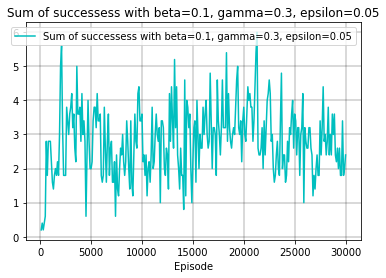

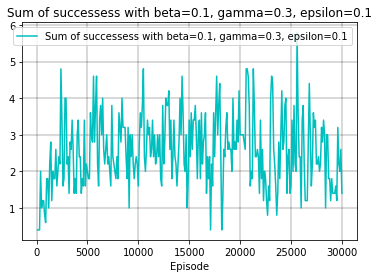

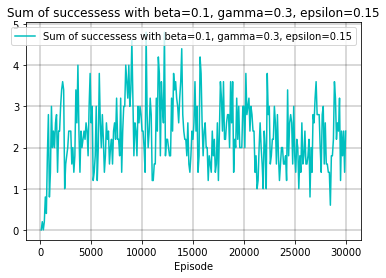

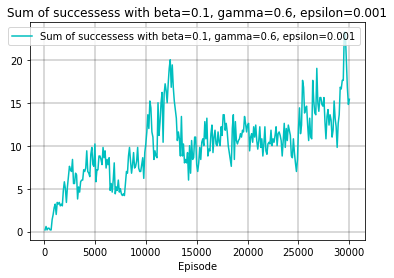

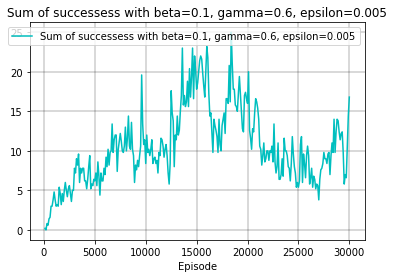

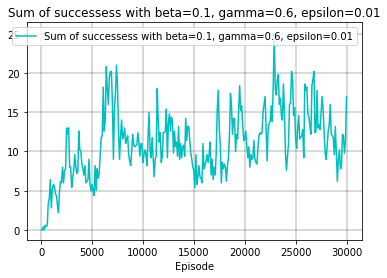

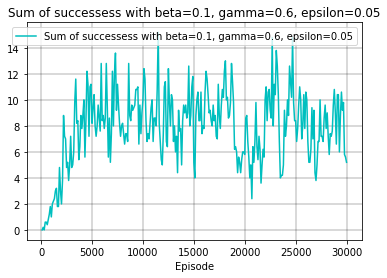

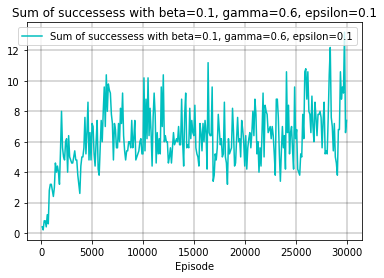

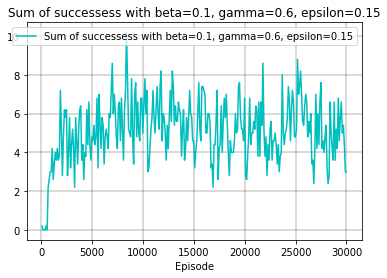

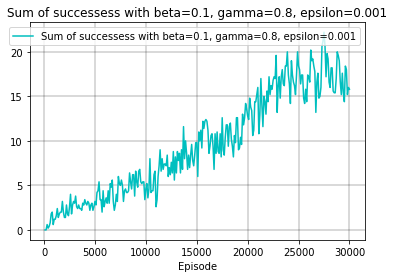

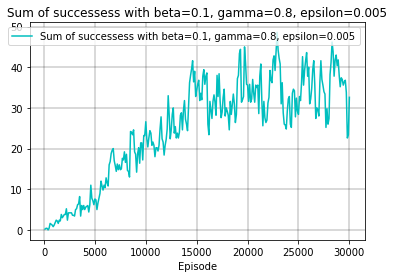

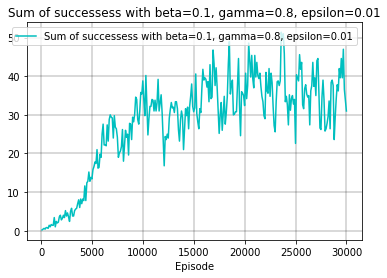

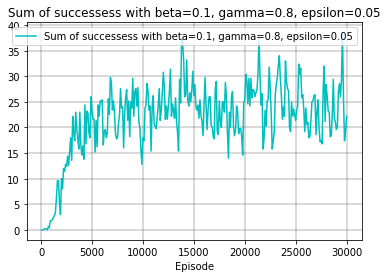

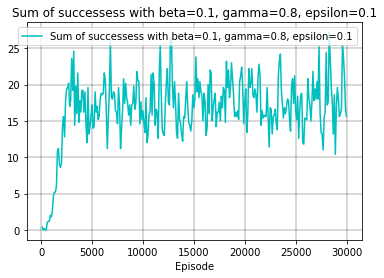

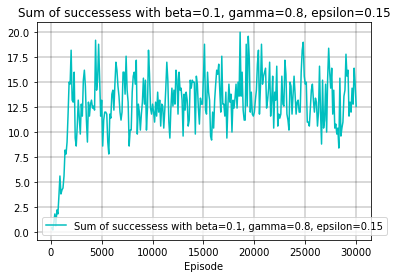

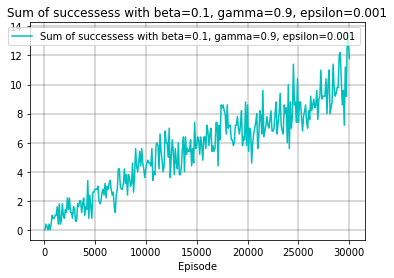

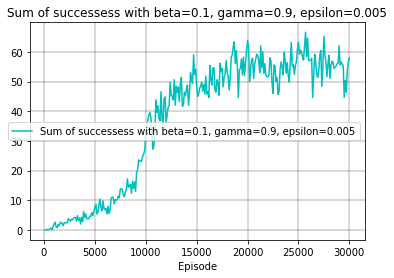

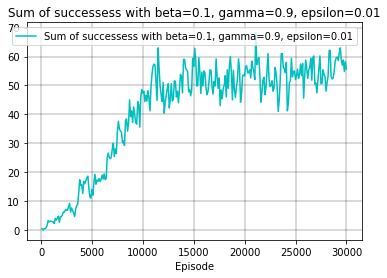

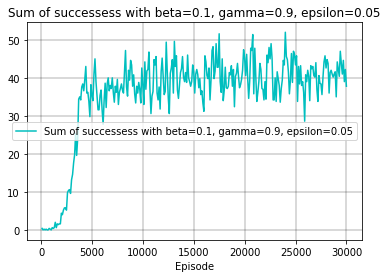

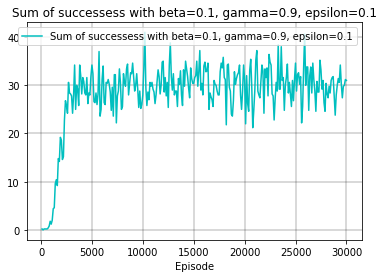

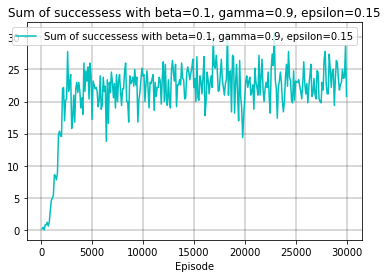

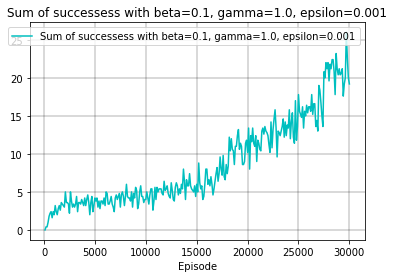

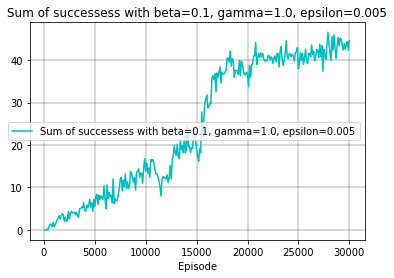

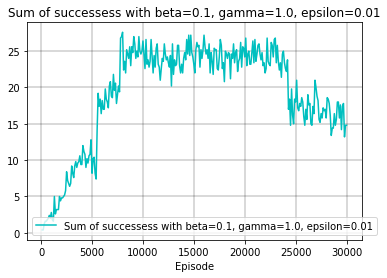

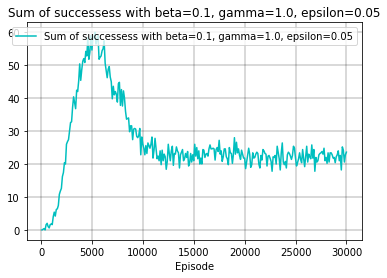

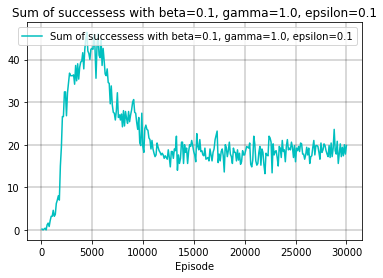

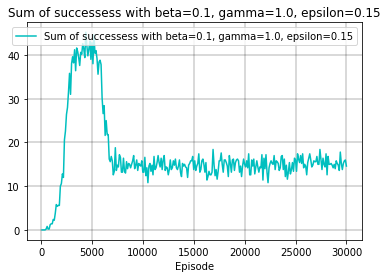

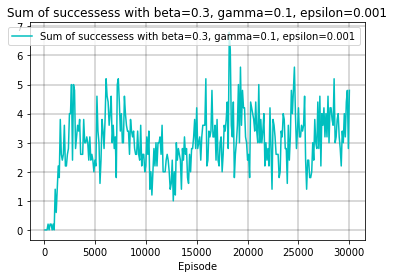

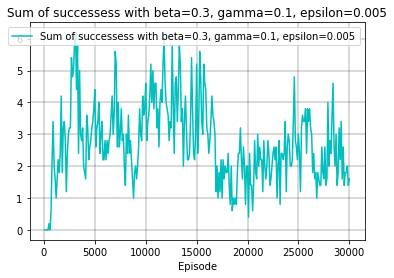

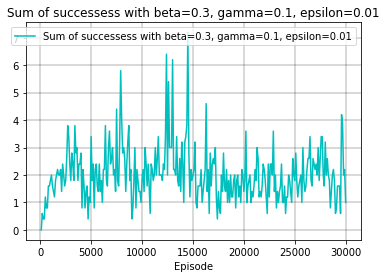

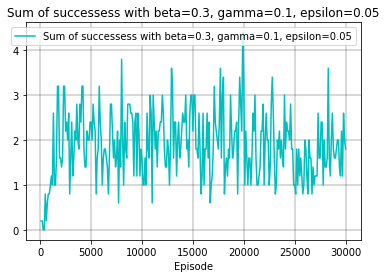

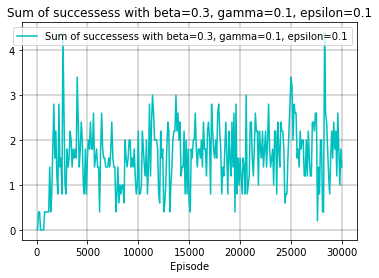

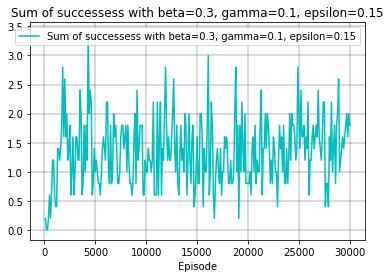

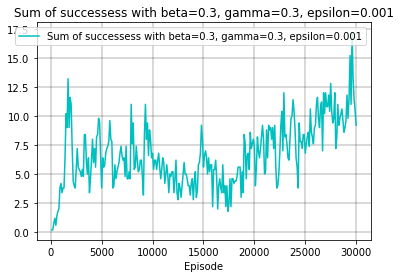

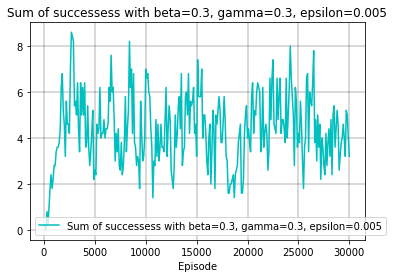

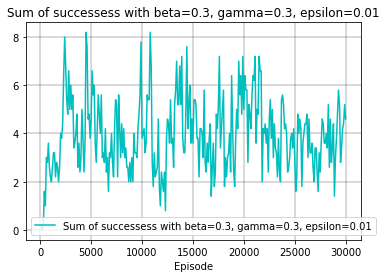

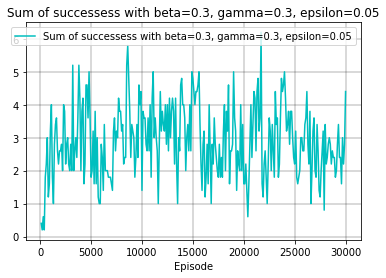

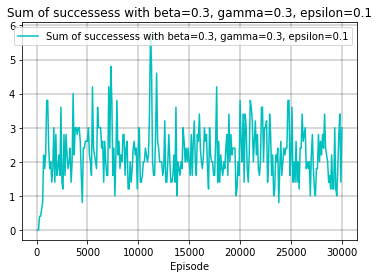

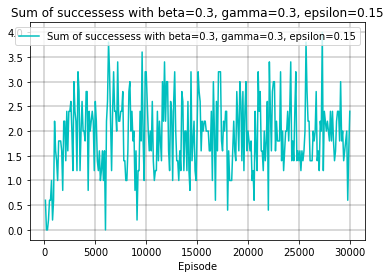

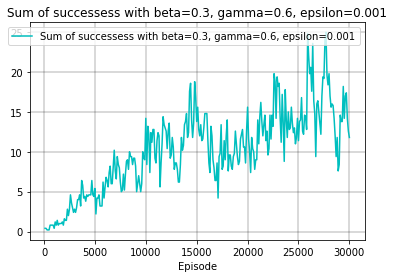

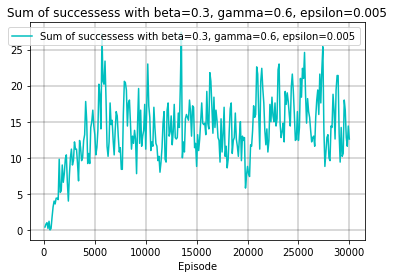

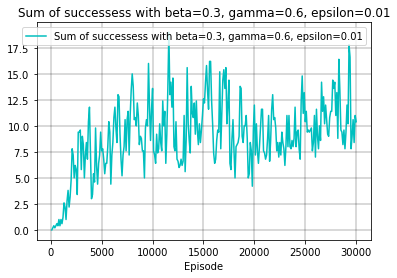

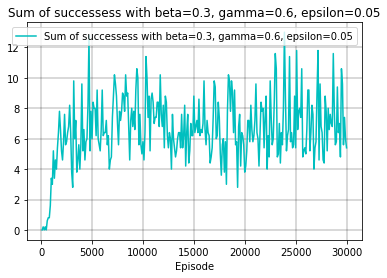

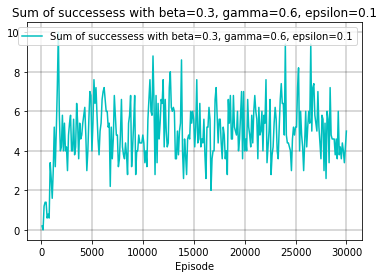

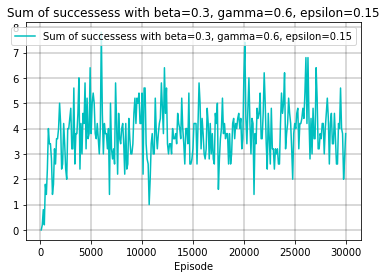

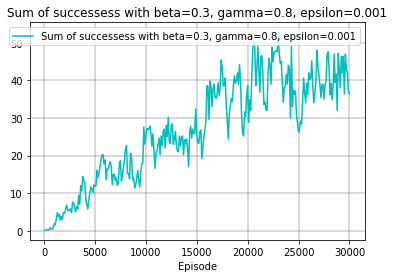

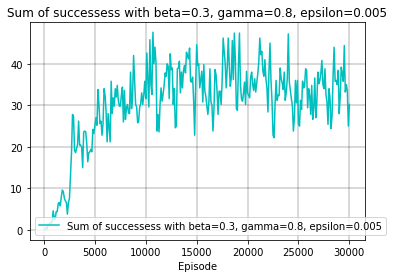

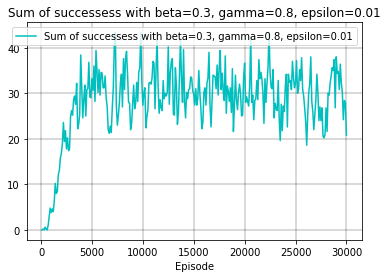

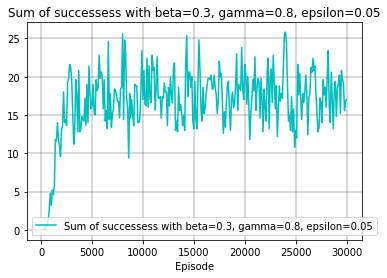

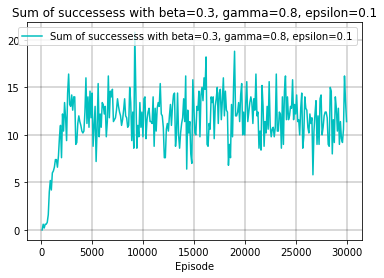

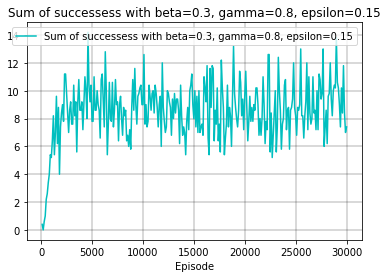

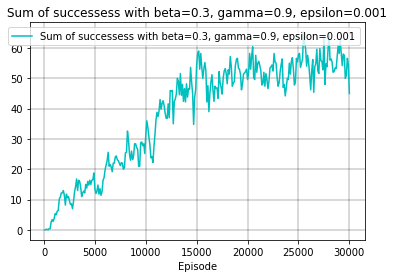

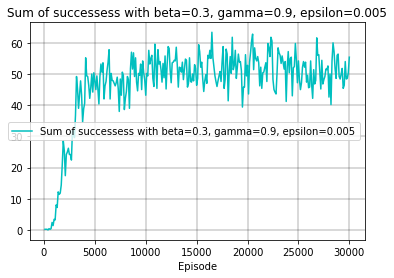

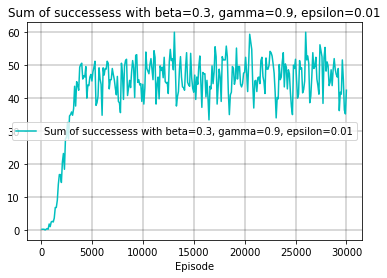

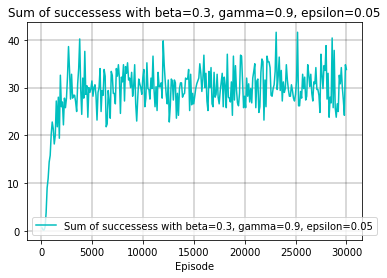

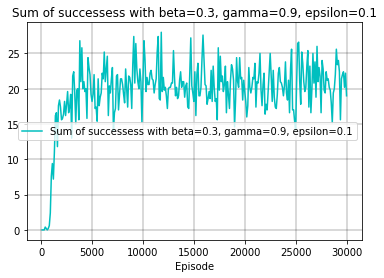

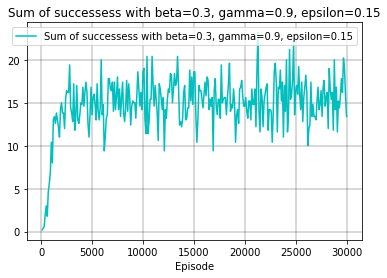

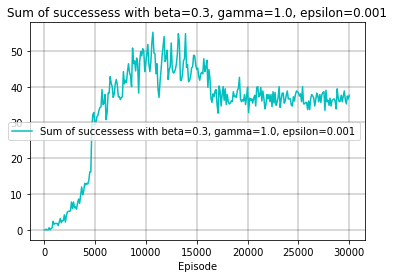

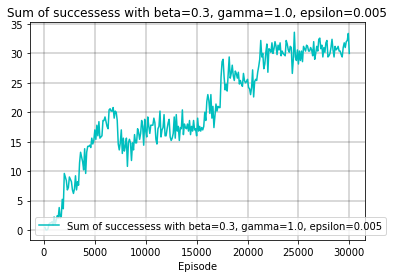

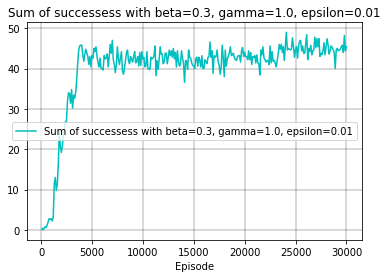

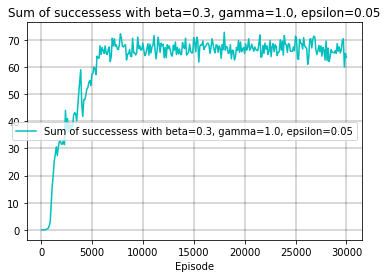

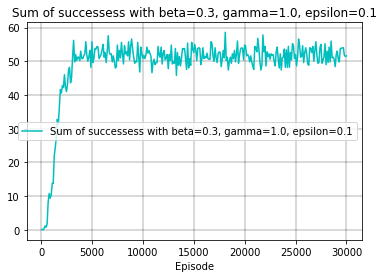

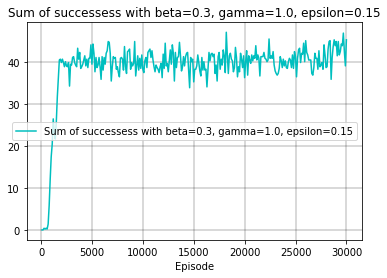

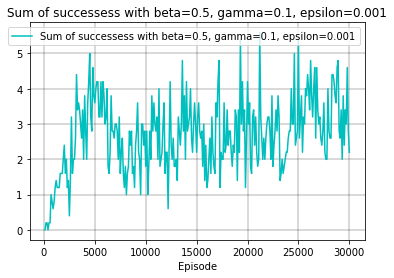

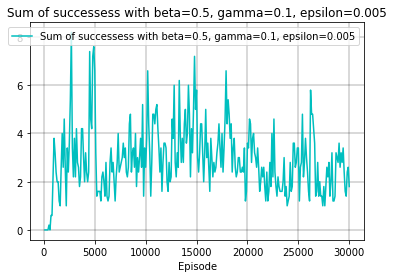

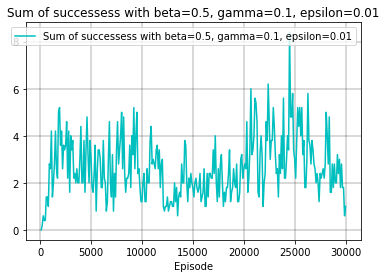

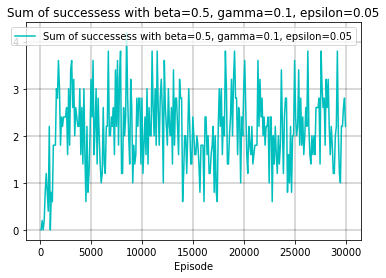

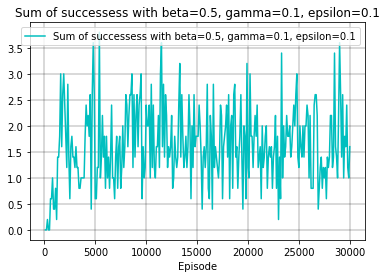

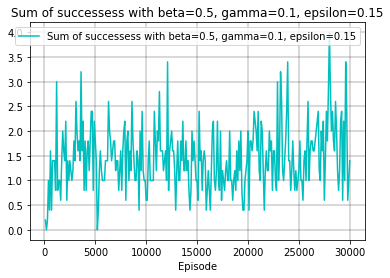

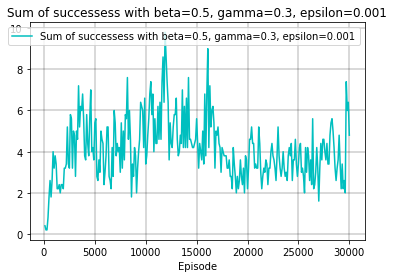

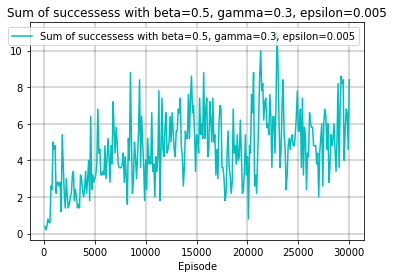

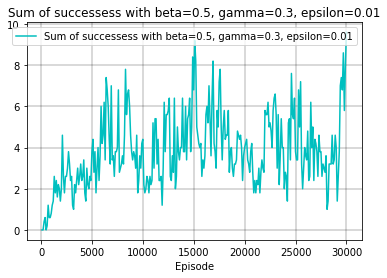

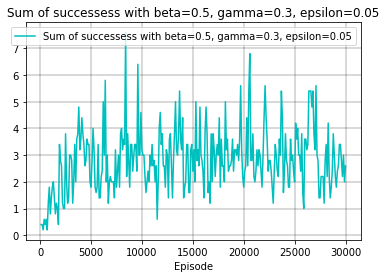

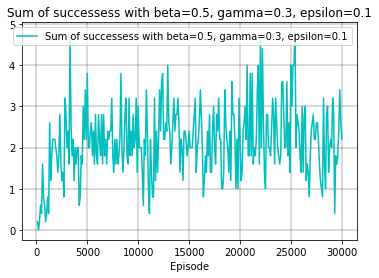

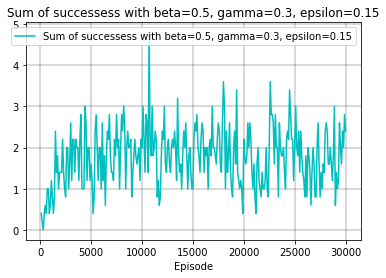

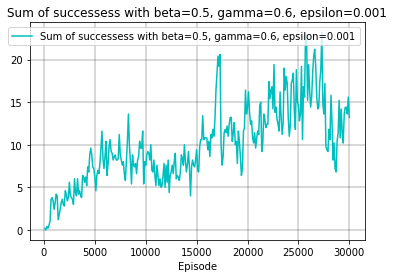

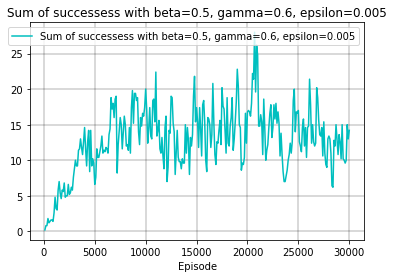

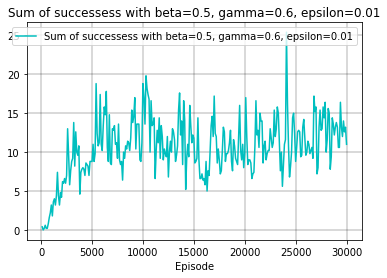

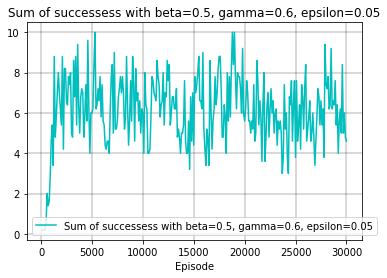

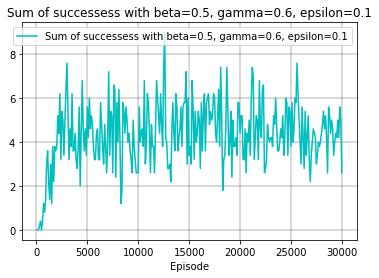

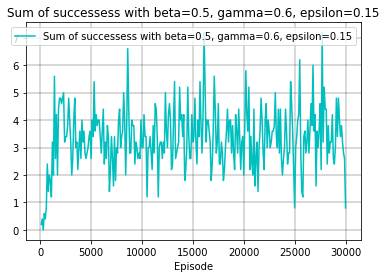

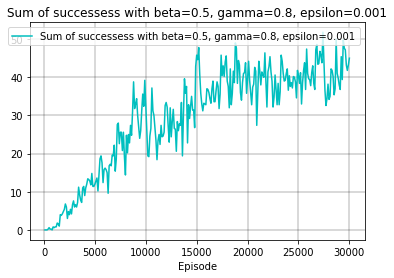

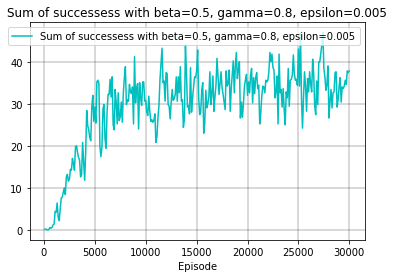

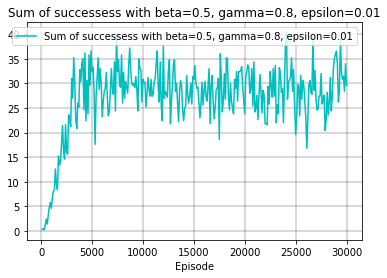

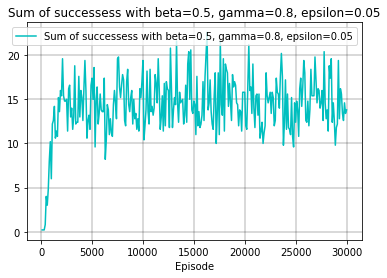

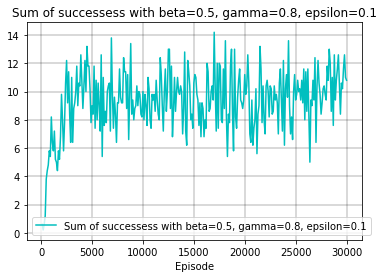

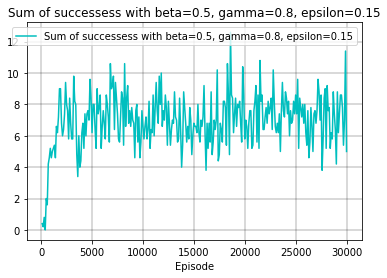

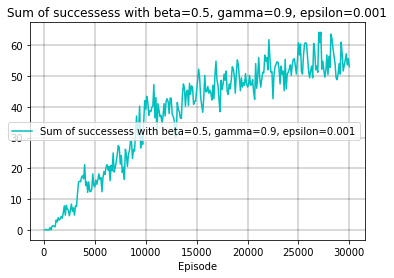

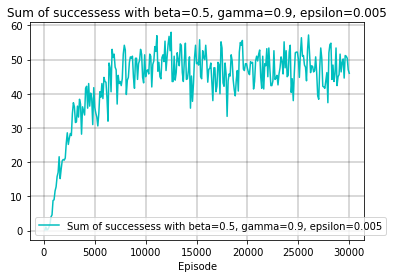

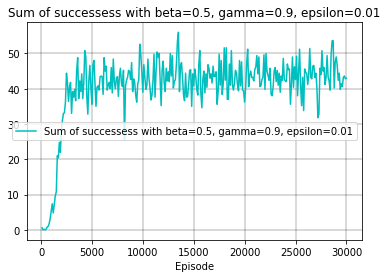

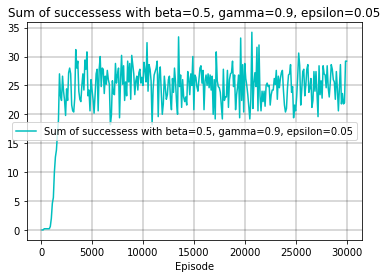

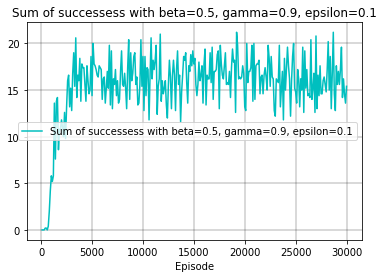

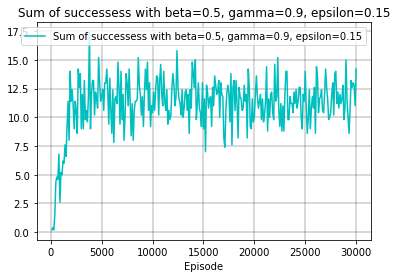

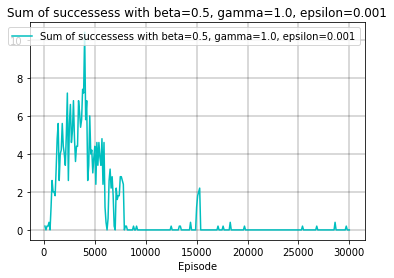

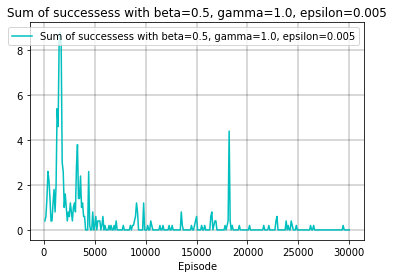

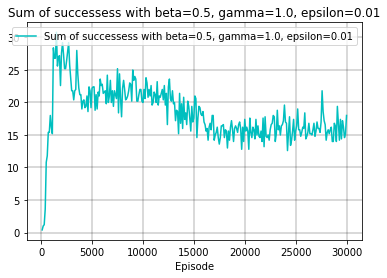

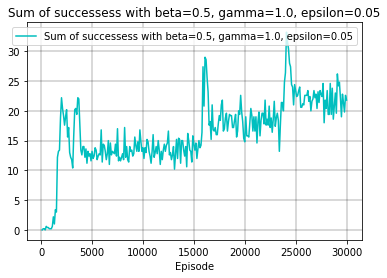

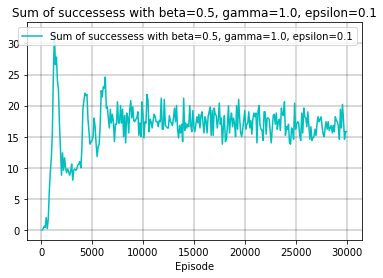

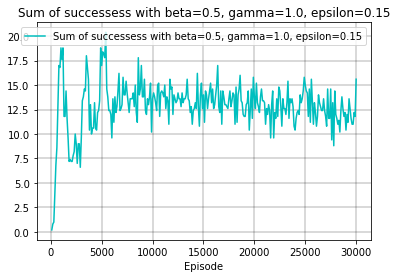

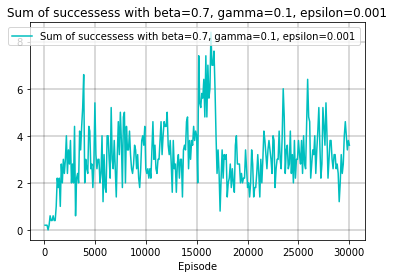

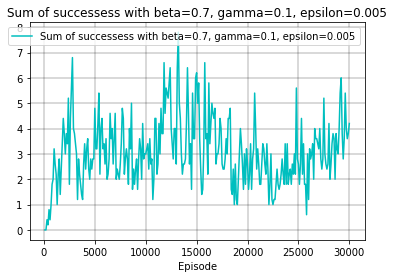

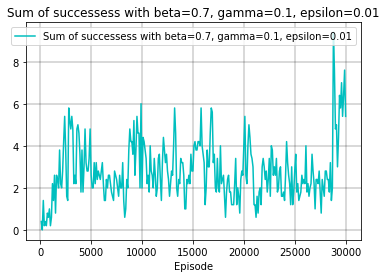

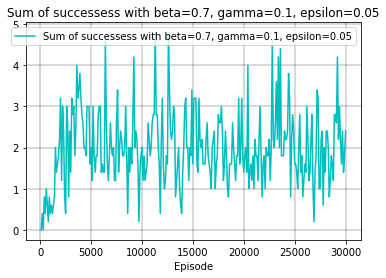

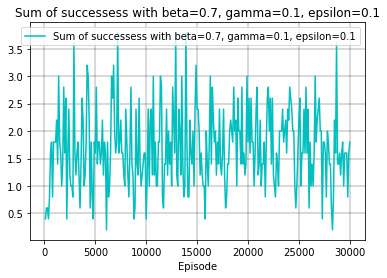

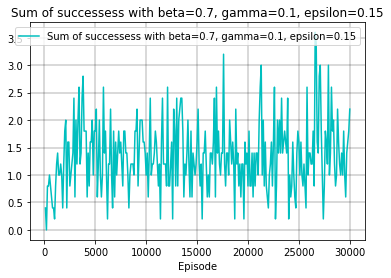

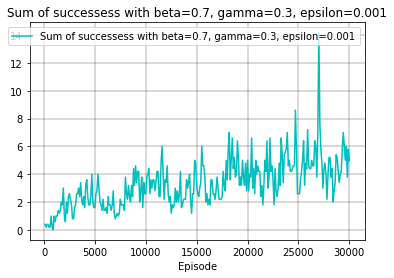

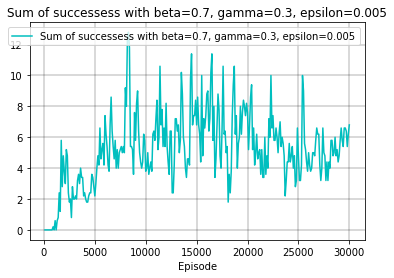

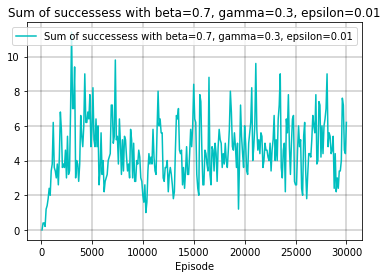

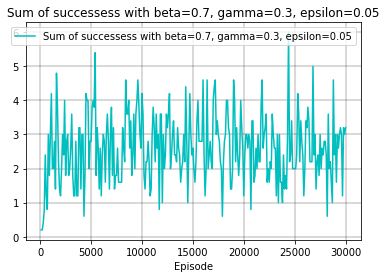

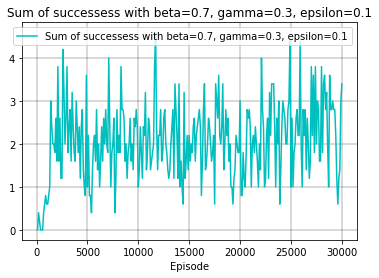

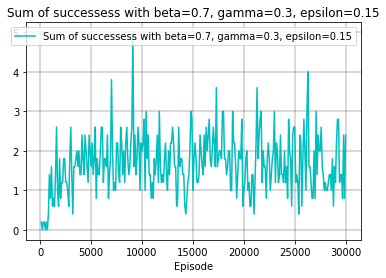

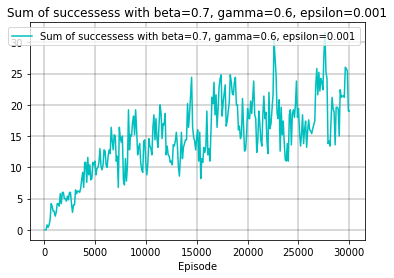

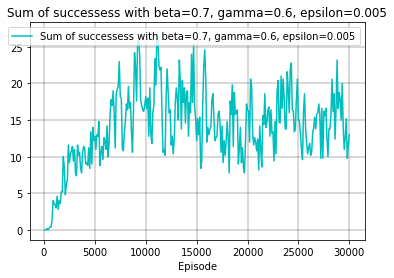

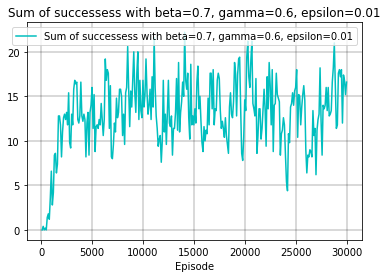

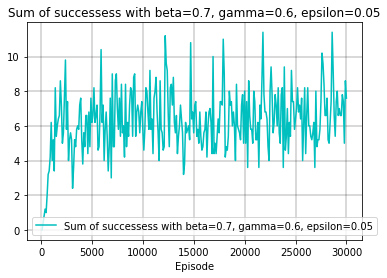

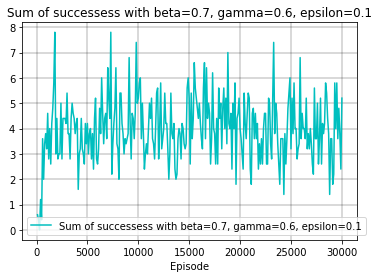

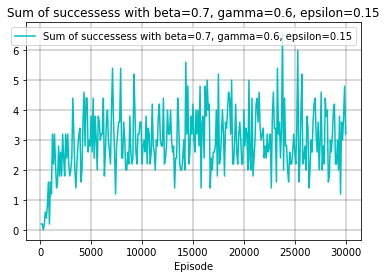

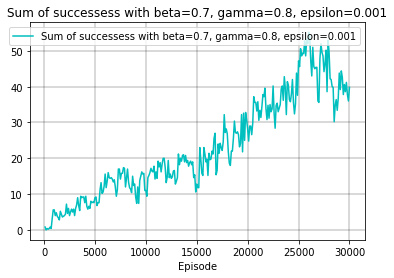

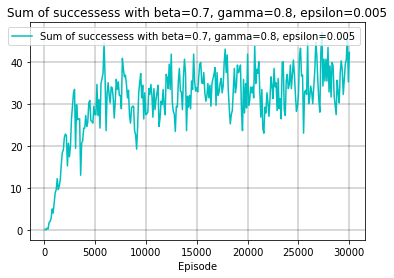

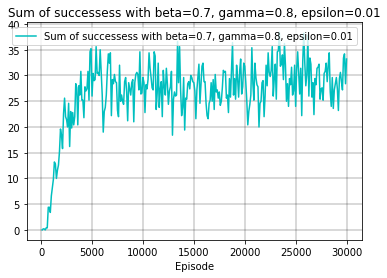

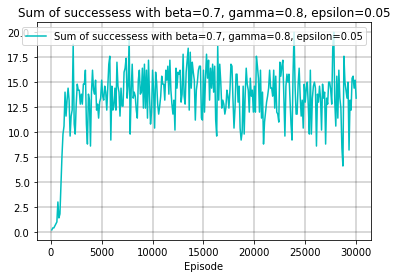

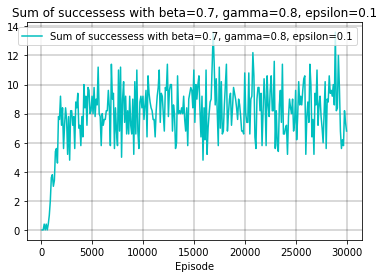

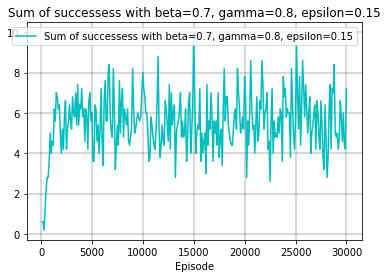

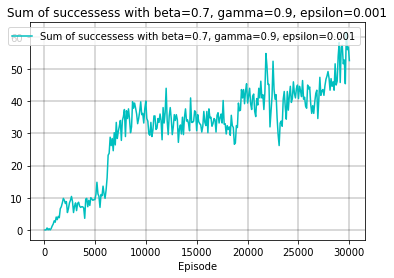

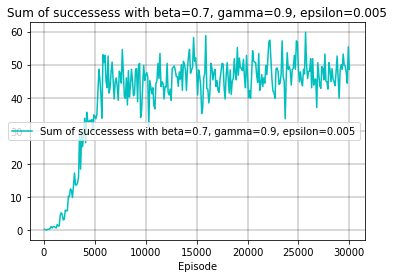

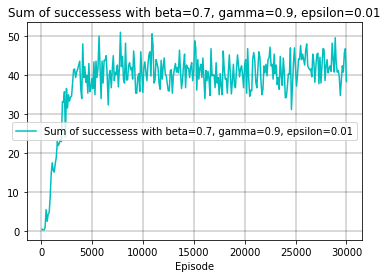

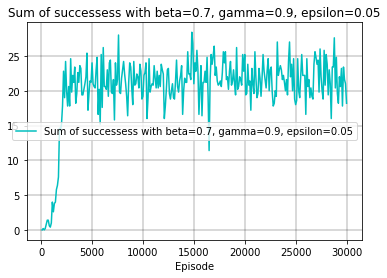

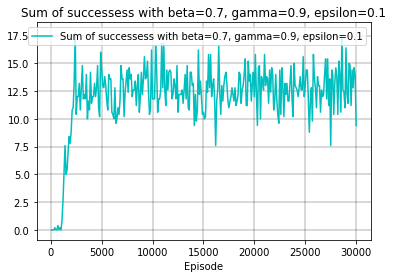

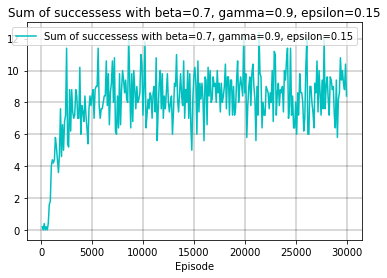

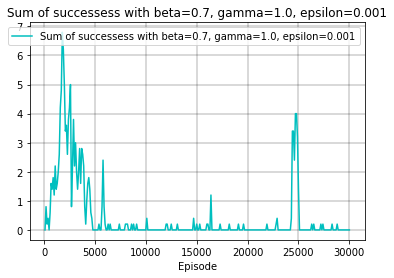

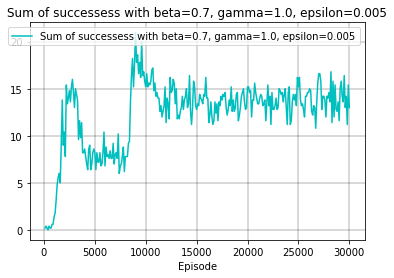

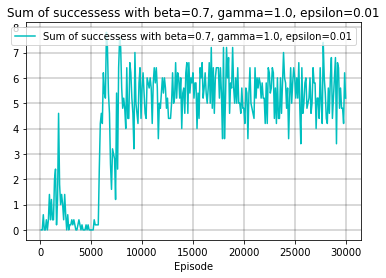

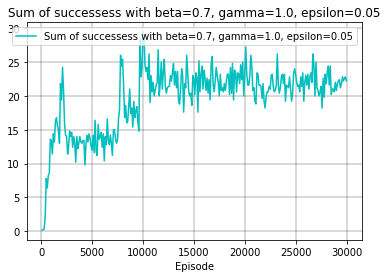

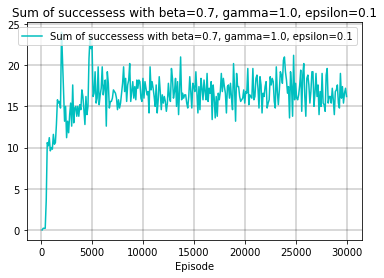

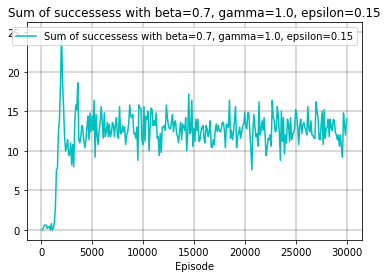

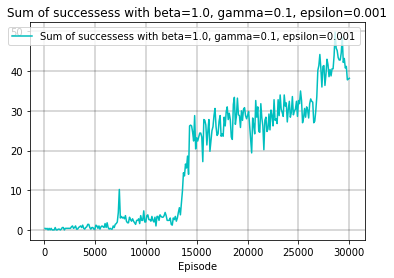

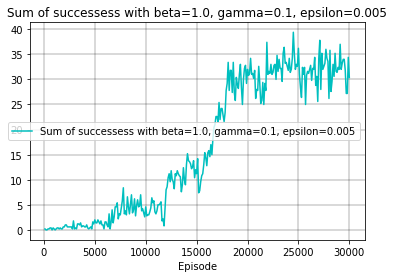

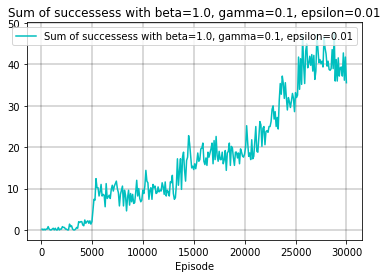

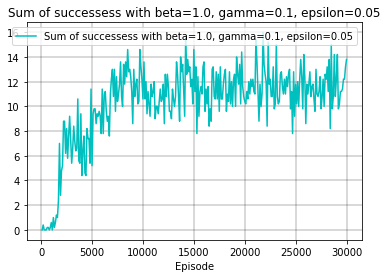

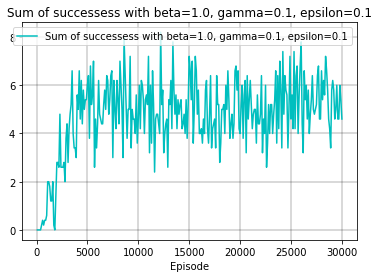

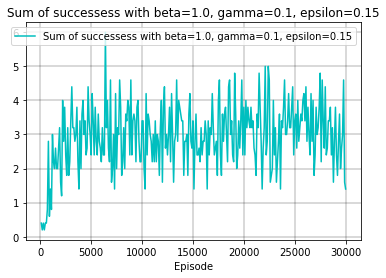

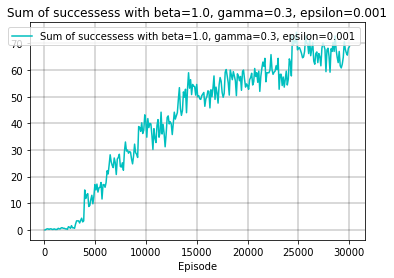

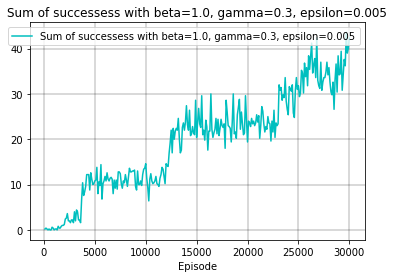

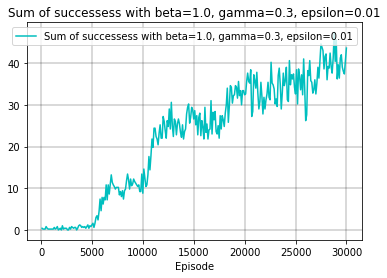

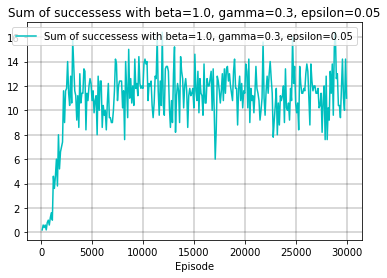

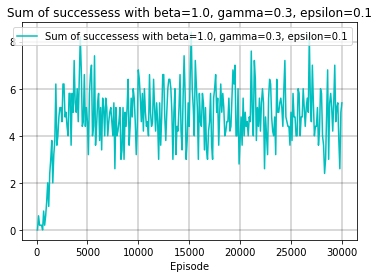

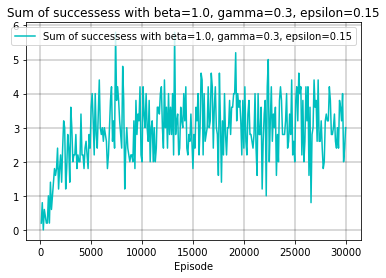

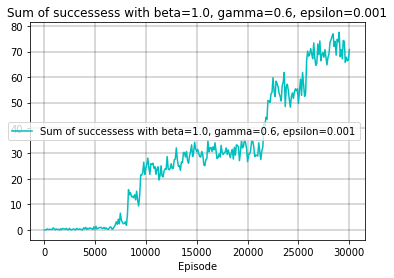

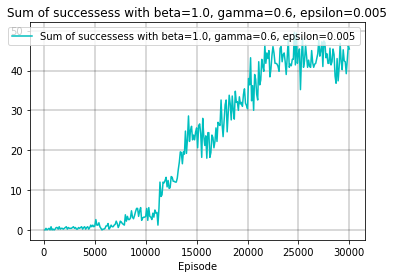

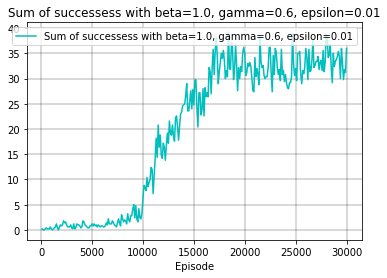

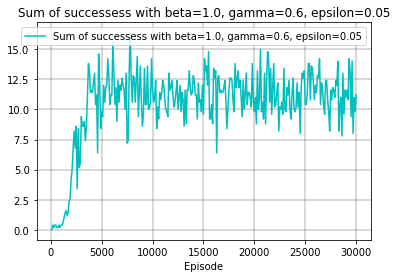

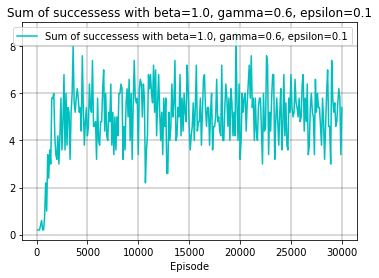

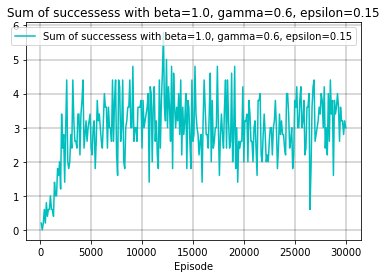

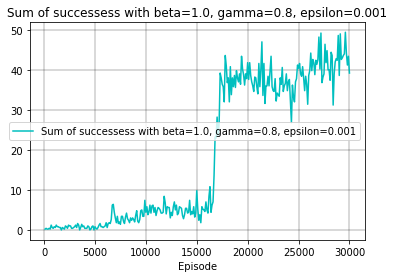

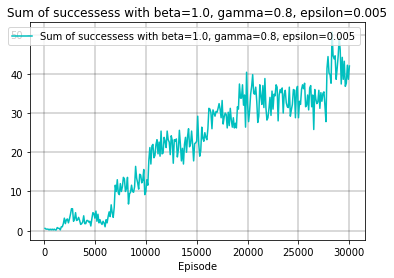

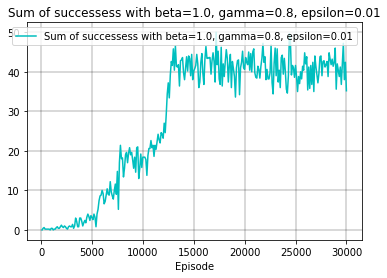

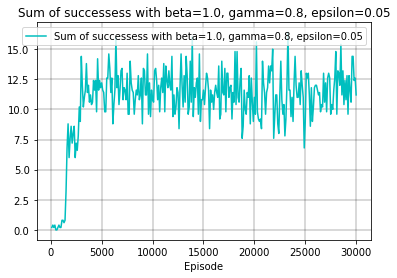

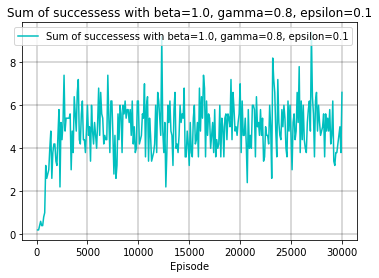

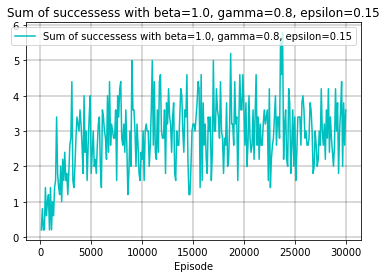

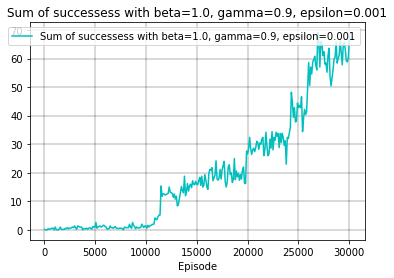

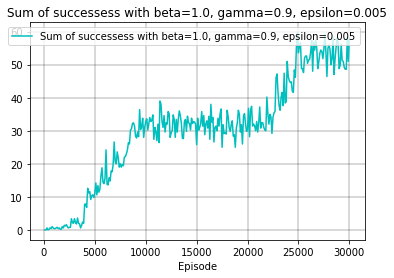

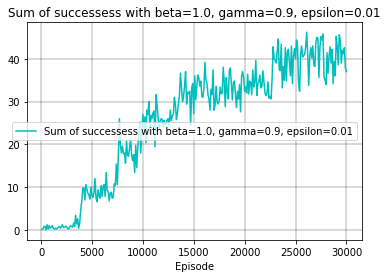

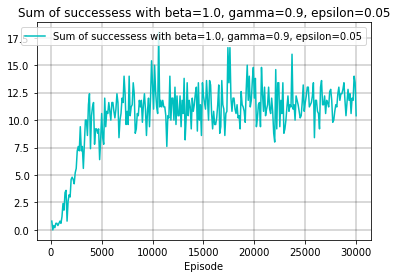

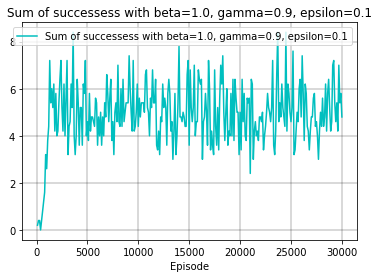

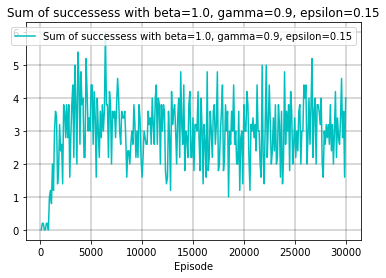

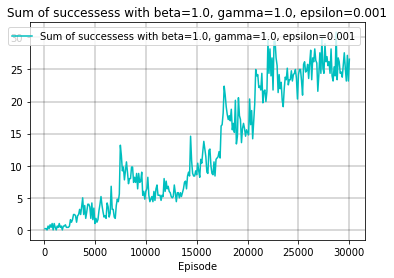

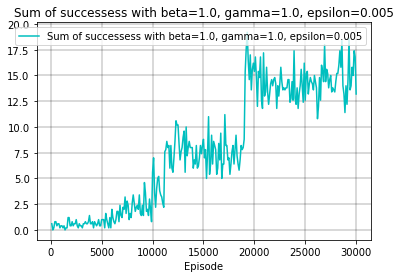

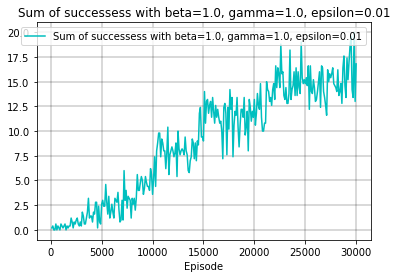

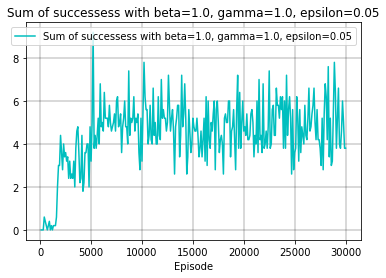

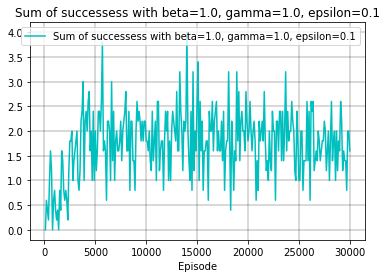

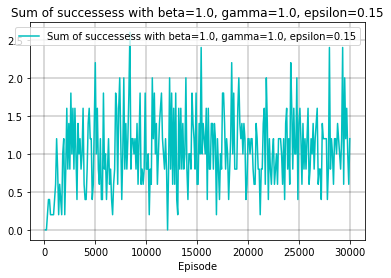

<Figure size 432x288 with 0 Axes>

In [8]:
validation()

## 6. Wnioski
+ Obserwacje na podstawie tych 216 symulacji można podzielić na 3 grupy. 
+ Pierwszą z nich stanowią takie sekwencje parametrów, które uczą agenta w sposób prawidłowy (po jakiejś liczbie epizodów, popełnia on ok. tylko 15-25% błędów na 100 epizodów.
    + Są to sekwencje parametrów:
        + beta = 0.05, gamma = 1.0, epsilon = 0.05, sukces ≈ 70%
        + beta = 0.3, gamma = 1.0, epsilon = 0.05, sukces ≈ 70%
        + beta = 1.0, gamma = 0.3, epsilon = 0.001, sukces ≈ 70%
        + beta = 1.0, gamma = 0.9, epsilon = 0.001, sukces ≈ 70%
        + beta = 0.05, gamma = 1.0, epsilon = 0.01, sukces ≈ 80%
        + beta = 1.0, gamma = 0.6, epsilon = 0.001, sukces ≈ 80%
+ Drugą grupę będą stanowiły parametry uznane za bardzo złe, tzn. w wyniku których nie następuje uczenie.
    + Dotyczy to zestawień beta = [0.05, 0.1, 0.3, 0.5, 0.7] i gamma = [0.1,  0.3].
    + Fatalne wyniki można rónież otrzymać dla beta=0.1, gamma = 1.0 i epsilon > 0.01. Mamy wtedy doczynienia z sytuacją, gdzie uczenie następuje bardzo opytymalnie, a następnie dochodzi do spadku w efektywności agenta.
+ Trzecią grupę tworzą zaś zestawienia parametrów, dzięki którym agent rzeczywiście uczy się, jednak nie udaje mu się go nauczyć wystarczająco dobrze, tzn. jego sukces wynosi od 30% do 60%.
+ Najważniejsze obserwacje:
    + parametr gamma powinien być liczbą bliską 1, świadczy on o długości horyzontu,
    + parametr epislon jest liczbą bliską zero, mówi on o tym z jakim prawdopodobieństwem eksplorujemy.